# 分类器的不确定度估计

scikit_learn接口的另一个用处是分类器能够给出预测的不确定度估计。一般来说，你感兴趣的不仅是分类器会预测一个测试点属于哪个类别，还包括它对这个预测的置信程度。在实践中，不同类型的错误会在现实应用中导致非常不同的结果。

scikit-learn中有两个函数可用于获取分类器的不确定度估计:decision_function和predict_proba。大多数分类器(但不是全部) 都至少有其中一个函数，很多分类器两个都有

In [1]:
# 构建一个GradientBoostingClassifier分类器
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles

# noise=0.25表示在生成的数据中添加了一些随机噪声。
# factor=0.5表示内圆和外圆的距离之间的比例因子。
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

print(X[:10])
print('\n')
y


[[-0.37748684 -0.0400769 ]
 [ 0.02701955 -0.48423931]
 [-0.36118825 -1.4007017 ]
 [-0.68154165  0.00577195]
 [ 0.79966997 -0.1374838 ]
 [-0.44067409  0.65738634]
 [-0.51680069 -0.64905973]
 [-0.48984706 -0.07126104]
 [-0.24030273  0.4245925 ]
 [-0.15480597  0.3987051 ]]




array([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0], dtype=int64)

In [2]:
# 将y的两个类别重命名为"blue"和"red"
import numpy as np
from sklearn.model_selection import train_test_split

y_name = np.array(['blue', 'red'])[y]

# 对任意个数组调用train_test_split
# 所有的数组划分方式都一样
X_train, X_test, y_train_name, y_test_name, y_train, y_test = train_test_split(X, y_name, y, random_state=0)

# 构建梯度提升模型
gbrt = GradientBoostingClassifier(random_state=0) # 基于梯度提升的集成学习方法
gbrt.fit(X_train, y_train_name)

GradientBoostingClassifier(random_state=0)

## 1. 决策函数

对于二分类的情况，decision_function 返回值的形状是(n_samples【要生成的样本数量】)，为每个样本都返回一个浮点数:

In [3]:
print("X_tets shape: {}".format(X_test.shape))
print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))

X_tets shape: (25, 2)
Decision function shape: (25,)


对于类别1来说，这个值表示模型对该数据点属于“正”类的置信程度。正值表示对正类的偏好，负值表示对“反类”(其他类)的偏好:

In [4]:
# 显示decision_function 的前几个元素
print("Decision function: \n{}".format(gbrt.decision_function(X_test)[:6]))

Decision function: 
[ 4.13592603 -1.67785652 -3.95106099 -3.62604651  4.28986642  3.66166081]


In [5]:
print("Thresholded decision function: \n{}".format(gbrt.decision_function(X_test)>0))
print('\n')
print("prediction: \n{}".format(gbrt.predict(X_test)))

Thresholded decision function: 
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]


prediction: 
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


对于二分类问题，“反”类始终是classes_属性的第一个元素，“正”类是classes_的第个元素。因此，如果你想要完全再现 predict 的输出，需要利用 classes_属性:

In [6]:
# 将布尔值转换为0和1
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# 利用0和1作为哦classes_的索引
pred = gbrt.classes_[greater_zero]
# pred 和 gbrt.predict的输出完全相同
# np.all 用于检查给定的条件是否对数组中的所有元素都成立。
print("pred is equal to predictions:{}".format(np.all(pred == gbrt.predict(X_test))))

pred is equal to predictions:True


decision_function 可以在任意范围取值，这取决于数据与模型参数:

In [7]:
decision_function = gbrt.decision_function(X_test)
print("Decision function minimum: {:.3f}, maximun:{:.3f}".
      format(np.min(decision_function), np.max(decision_function)))

Decision function minimum: -7.691, maximun:4.290


由于可以任意缩放，因此decision_function 的输出往往很难解释

在下面的例子中，我们利用颜色编码在二维平面中画出所有点的 decision_function，还有决策边界，后者我们之间见过。我们将训练点画成圆，将测试数据画成三角:

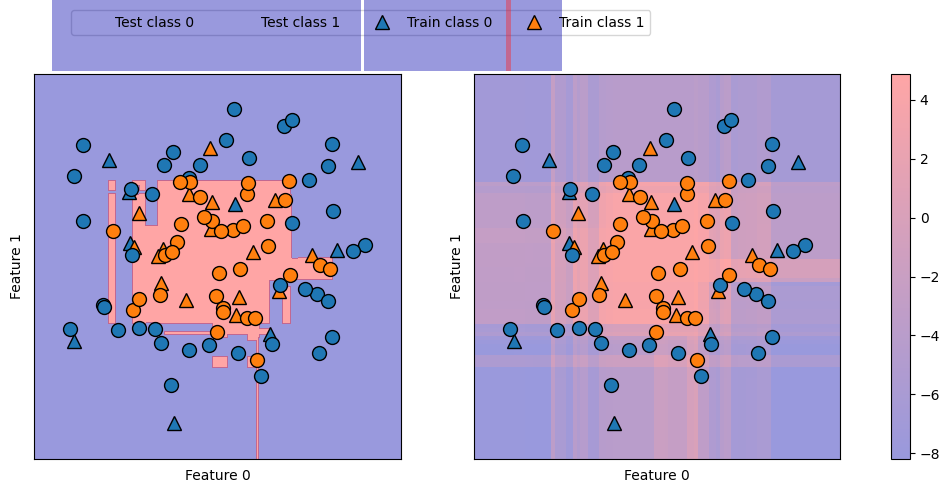

In [8]:
import matplotlib.pyplot as plt
import mglearn

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 画出训练点和测试点
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o',ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))
# 梯度提升模型在一个二维玩具数据集上的决策边界(左)和决策函数(右)

既给出预测结果，又给出分类器的置信程度，这样给出的信息量更大。但在上面的图像中，很难分辨出两个类别之间的边界。

## 2. 预测概率 

predict_proba的输出是每个类别的概率，通常比deision_function 的输出更容易理解对于二分类问题，它的形状始终是(n_samples，2):

In [9]:
print("Shape of probabilities: {}".format(gbrt.predict_proba(X_test).shape))

Shape of probabilities: (25, 2)


每行的第一个元素是第一个类别的估计概率，第二个元素是第二个类别的估计概率。由于predict_proba的输出是一个概率，因此总是在0和1之间，两个类别的元素之和始终为1:

In [10]:
# 显示predict_proba的前几个元素
print("predicted probabilities:\n{}".format(gbrt.predict_proba(X_test[:6])))

predicted probabilities:
[[0.01573626 0.98426374]
 [0.84262049 0.15737951]
 [0.98112869 0.01887131]
 [0.97406909 0.02593091]
 [0.01352142 0.98647858]
 [0.02504637 0.97495363]]


由于两个类别的概率之和为1，因此只有一个类别的概率超过 50%。这个类别就是模型的预测结果。

在上一个输出中可以看到，分类器对大部分点的置信程度都是相对较高的。不确定度大小实际上反映了数据依赖于模型和参数的不确定度。过拟合更强的模型可能会做出置信程度更高的预测，即使可能是错的。复杂度越低的模型通常对预测的不确定度越大。如果模型给出的不确定度符合实际情况，那么这个模型被称为校正 (calibrated) 模型。在校正模型中，如果预测有 70%的确定度，那么它在70%的情况下正确。

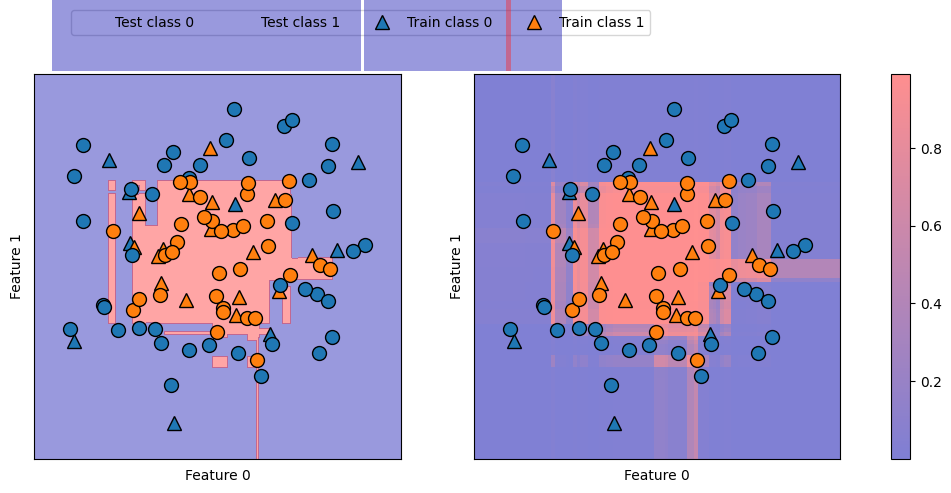

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 画出训练点和测试点
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")

cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0", "Train class 1"], ncol=4, loc=(.1, 1.1))


这张图中的边界更加明确，不确定的小块区域清晰可见

## 3. 多分类问题的不确定度

到目前为止，我们只讨论了二分类向题中的不确定度估计。但 decision_function 和predict_proba也适用于多分类问题。

In [12]:
#将这两个函数应用于鸢尾花(Iris)数据集，这是一个三分类数据集:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)
gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

print("Decision function shape: {}".format(gbrt.decision_function(X_test).shape))
# 显示决策函数的前几个元素
print("Decision function: {}".format(gbrt.decision_function(X_test)[:6, :]))

Decision function shape: (38, 3)
Decision function: [[-1.995715    0.04758267 -1.92720695]
 [ 0.06146394 -1.90755736 -1.92793758]
 [-1.99058203 -1.87637861  0.09686725]
 [-1.995715    0.04758267 -1.92720695]
 [-1.99730159 -0.13469108 -1.20341483]
 [ 0.06146394 -1.90755736 -1.92793758]]


对于多分类的情况，decision_function 的形状为(n_samples，n_classes)，每一列对应每个类别的“确定度分数”，分数较高的类别可能性更大，得分较低的类别可能性较小。你可以找出每个数据点的最大元素，从而利用这些分数再现预测结果:

In [13]:
print("Argmax of decision function:\n {}".format(np.argmax(gbrt.decision_function(X_test), axis=1)))
print("predictions:\n{}".format(gbrt.predict(X_test)))

Argmax of decision function:
 [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
predictions:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


predict_proba输出的形状相同，也是(n_samples，n_classes)。同样，每个数据点所有可能类别的概率之和为 1:

In [14]:
# 显示predict_proba的前几个元素
print("predicted probabilities:\n{}\n".format(gbrt.predict_proba(X_test)[:6]))

# 显示每行的和都是1
print("Sum:{}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

predicted probabilities:
[[0.10217718 0.78840034 0.10942248]
 [0.78347147 0.10936745 0.10716108]
 [0.09818072 0.11005864 0.79176065]
 [0.10217718 0.78840034 0.10942248]
 [0.10360005 0.66723901 0.22916094]
 [0.78347147 0.10936745 0.10716108]]

Sum:[1. 1. 1. 1. 1. 1.]


同样，我们可以通过计算 predict_proba的argmax来再现预测结果:

In [15]:
print("Argmax of predicted probabilities:\n{}".format(np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("Prediections:\n{}".format(gbrt.predict(X_test)))

Argmax of predicted probabilities:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
Prediections:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


总之、predict_proba和decision_function的形状始终相同，都是(n_samples，nclasses)---除了二分类特殊情况下的 decision_function。对于二分类的情况，decisionfunction 只有一列，对应“正”类classes_[1]。这主要是由于历史原因。

如果有n_classes列，你可以通过计算每一列的 argmax 来再现预测结果。但如果类别是字符串，或者是整数，但不是从0开始的连续整数的话，一定要小心。如果你想要对比predict的结果与decision_function或predict proba的结果，一定要用分类器的classes_属性来获取真实的属性名称:

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
# 用iris数据集的类别名称来表示每一个目标值
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("unique classes in training data: {}\n".format(logreg.classes_))
print("Predictions: {}\n".format(logreg.predict(X_test)[:10]))
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("Argmax of decision function: {}\n".format(argmax_dec_func[:10]))
print("Argmax combined with classes_: {}\n".format(logreg.classes_[argmax_dec_func][:10]))

unique classes in training data: ['setosa' 'versicolor' 'virginica']

Predictions: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']

Argmax of decision function: [1 0 2 1 1 0 1 2 1 1]

Argmax combined with classes_: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']



d:\python\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
